# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 


In [393]:
import logging
logging.getLogger("scapy.runtime").setLevel(logging.ERROR)

from netml.pparser.parser import PCAP
from netml.utils.tool import dump_data, load_data

import pandas as pd

In [394]:
pcap = PCAP('../notebooks/data/netflix.pcap', flow_ptks_thres=2, verbose=10)

In [395]:
pcap.pcap2pandas()

pdf = pcap.df

'_pcap2pandas()' starts at 2023-10-24 04:19:57
'_pcap2pandas()' ends at 2023-10-24 04:20:50 and takes 0.8847 mins.


### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [396]:
NF_DOMAINS = ["nflxvideo", 
              "netflix", 
              "nflxso", 
              "nflxext"]

In [397]:
nfre = '|'.join(NF_DOMAINS)

In [398]:
df = pdf[pdf['is_dns']]
df.head(4)


,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
0,2018-02-11 08:10:00,"(fonts.gstatic.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,77,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,55697.0,UDP,1518358200.534682,0.000000
1,2018-02-11 08:10:00,"(fonts.gstatic.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,77,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,59884.0,UDP,1518358200.534832,0.000150
2,2018-02-11 08:10:00,"(googleads.g.doubleclick.net.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,87,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,61223.0,UDP,1518358200.539408,0.004726
3,2018-02-11 08:10:00,"(googleads.g.doubleclick.net.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,87,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,58785.0,UDP,1518358200.541204,0.006522


In [399]:
def get_first_value(t):
    return t[0]
df = df.applymap(lambda x: get_first_value(x) if isinstance(x, tuple) else x)

In [400]:
nfre = '|'.join(NF_DOMAINS)
onlynetflixdf = df[df['dns_query'].str.contains(nfre, regex=True, na=False) | df['dns_resp'].str.contains(nfre, regex=True, na=False)]

### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [401]:
pcap.pcap2flows()

'_pcap2flows()' starts at 2023-10-24 04:20:50
pcap_file: ../notebooks/data/netflix.pcap
ith_packets: 0
ith_packets: 10000
ith_packets: 20000
ith_packets: 30000
ith_packets: 40000
ith_packets: 50000
ith_packets: 60000
ith_packets: 70000
ith_packets: 80000
ith_packets: 90000
ith_packets: 100000
ith_packets: 110000
ith_packets: 120000
ith_packets: 130000
ith_packets: 140000
len(flows): 275
total number of flows: 275. Num of flows < 2 pkts: 91, and >=2 pkts: 184 without timeout splitting.
kept flows: 184. Each of them has at least 2 pkts after timeout splitting.
flow_durations.shape: (184, 1)
        col_0
count 184.000
mean   82.331
std   127.700
min     1.138
25%    14.428
50%    17.122
75%    71.087
max   486.705
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   col_0   184 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB
None
0th_flow: len(pkts

In [402]:
pcap.flow2features('STATS', fft=False, header=False)
stats = pd.DataFrame(pcap.features)
print(len(stats))
stats.head(4)

'_flow2features()' starts at 2023-10-24 04:21:26
True
'_flow2features()' ends at 2023-10-24 04:21:27 and takes 0.0218 mins.
184


,0,1,2,3,4,5,6,7,8,9,10,11
0,11.462,1.047,93.530,89.333,49.601,66.000,66.000,69.000,66.000,200.000,12.000,1072.000
1,248.797,0.269,22.283,82.746,41.922,66.000,66.000,66.000,54.000,200.000,67.000,5544.000
2,19.350,0.258,17.675,68.400,4.800,66.000,66.000,66.000,66.000,78.000,5.000,342.000
3,19.349,0.258,17.675,68.400,4.800,66.000,66.000,66.000,66.000,78.000,5.000,342.000


**Write a brief justification for the features that you have chosen.**

<p>Candidates for features include IAT, STATS, SIZE, SAMP-NUM, and SAMP-SIZE. IAT and SIZE contained numerous "zero" points, and would likely prove difficult to use while training. Additionally, STATS has a large number of non-zero values as well as further statistics on packet size. This flexibility of nonzero data is what encouraged me to pick this feature.

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [403]:
stats['segment downloads rate'] = 0
stats.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,segment downloads rate
0,11.462,1.047,93.530,89.333,49.601,66.000,66.000,69.000,66.000,200.000,12.000,1072.000,0
1,248.797,0.269,22.283,82.746,41.922,66.000,66.000,66.000,54.000,200.000,67.000,5544.000,0
2,19.350,0.258,17.675,68.400,4.800,66.000,66.000,66.000,66.000,78.000,5.000,342.000,0
3,19.349,0.258,17.675,68.400,4.800,66.000,66.000,66.000,66.000,78.000,5.000,342.000,0


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [404]:
nflxsession = pd.read_pickle('netflix_session.pkl')
videodataset = pd.read_pickle('video_dataset.pkl')

### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 280, 360, 480, 720, 1080.

In [405]:
allowed_resolutions = [280, 360, 480, 720, 1080]

ds_filtered = videodataset[videodataset['resolution'].isin(allowed_resolutions)]
print(ds_filtered.shape)
ds_filtered['resolution']

(154525, 170)


0        360.000
1        360.000
2        360.000
3        360.000
4        480.000
           ...  
204708   720.000
204709   720.000
204710   720.000
204711   720.000
204712   720.000
Name: resolution, Length: 154525, dtype: float64

In [406]:
for column in ds_filtered.columns:
    if isinstance(ds_filtered[column].iloc[0], str):
        ds_filtered = ds_filtered.drop(columns=[column])
ds_filtered.head()

,L7_10_avg_chunksize,L7_10_chunksizes_50,L7_10_chunksizes_75,L7_10_chunksizes_85,L7_10_chunksizes_90,L7_10_max_chunksize,L7_10_min_chunksize,L7_10_std_chunksize,absolute_timestamp,L7_all_prev_down_chunk_iat_50,L7_all_prev_down_chunk_iat_75,L7_all_prev_down_chunk_iat_85,L7_all_prev_down_chunk_iat_90,L7_all_prev_down_chunk_iat_avg,L7_all_prev_down_chunk_iat_max,L7_all_prev_down_chunk_iat_min,L7_all_prev_down_chunk_iat_std,L7_all_prev_up_chunk_iat_50,L7_all_prev_up_chunk_iat_75,L7_all_prev_up_chunk_iat_85,L7_all_prev_up_chunk_iat_90,L7_all_prev_up_chunk_iat_avg,L7_all_prev_up_chunk_iat_max,L7_all_prev_up_chunk_iat_min,L7_all_prev_up_chunk_iat_std,L7_allprev_avg_chunksize,L7_allprev_chunksizes_50,L7_allprev_chunksizes_75,L7_allprev_chunksizes_85,L7_allprev_chunksizes_90,L7_allprev_max_chunksize,L7_allprev_min_chunksize,L7_allprev_std_chunksize,L7_cumsum_chunksizes,L7_cumsum_diff,L7_down_chunk_iat_50,L7_down_chunk_iat_75,L7_down_chunk_iat_85,L7_down_chunk_iat_90,L7_down_chunk_iat_avg,L7_down_chunk_iat_max,L7_down_chunk_iat_min,L7_down_chunk_iat_std,index,L7_n_chunks_down,L7_n_chunks_up,L7_n_prev_down_chunk,L7_n_prev_up_chunk,L3_parallel_flows,relative_timestamp,resolution,L3_service_Video_throughput_down,L3_service_Video_throughput_up,L3_service_non_video_throughput_down,L3_service_non_video_throughput_up,L3_total_throughput_down,L3_total_throughput_up,L7_up_chunk_iat_50,L7_up_chunk_iat_75,L7_up_chunk_iat_85,L7_up_chunk_iat_90,L7_up_chunk_iat_avg,L7_up_chunk_iat_max,L7_up_chunk_iat_min,L7_up_chunk_iat_std,L7_up_down_ratio,video_position,L4_serverAckFlags,L4_serverAvgBytesInFlight,L4_serverAvgBytesPerPacket,L4_serverAvgRetransmit,L4_serverAvgRwnd,L3_serverByteCount,L4_serverEndBytesPerPacket,L4_serverFinFlags,L4_serverGoodput,L4_serverIdleTime,L4_serverKurBytesInFlight,L4_serverKurBytesPerPacket,L4_serverKurRetransmit,L4_serverKurRwnd,L4_serverMaxBytesInFlight,L4_serverMaxBytesPerPacket,L4_serverMaxRetransmit,L4_serverMaxRwnd,L4_serverMedBytesInFlight,L4_serverMedBytesPerPacket,L4_serverMedRetransmit,L4_serverMedRwnd,L4_serverMinBytesInFlight,L4_serverMinBytesPerPacket,L4_serverMinRetransmit,L4_serverMinRwnd,L4_serverOneRetransmit,L4_serverOutOfOrderBytes,L4_serverOutOfOrderPackets,L3_serverPacketCount,L4_serverPshFlags,L4_serverRstFlags,L4_serverSkeBytesInFlight,L4_serverSkeBytesPerPacket,L4_serverSkeRetransmit,L4_serverSkeRwnd,L4_serverStdBytesInFlight,L4_serverStdBytesPerPacket,L4_serverStdRetransmit,L4_serverStdRwnd,L4_serverStrBytesPerPacket,L4_serverSynFlags,L4_serverTwoRetransmit,L4_serverUrgFlags,L4_serverXRetransmit,L4_serverZeroRetransmit,L4_userAckFlags,L4_userAvgBytesInFlight,L4_userAvgBytesPerPacket,L4_userAvgRTT,L4_userAvgRetransmit,L4_userAvgRwnd,L3_userByteCount,L4_userEndBytesInFlight,L4_userFinFlags,L4_userGoodput,L4_userIdleTime,L4_userKurBytesInFlight,L4_userKurBytesPerPacket,L4_userKurRTT,L4_userKurRetransmit,L4_userKurRwnd,L4_userMaxBytesInFlight,L4_userMaxBytesPerPacket,L4_userMaxRTT,L4_userMaxRetransmit,L4_userMaxRwnd,L4_userMedBytesInFlight,L4_userMedBytesPerPacket,L4_userMedRTT,L4_userMedRetransmit,L4_userMedRwnd,L4_userMinBytesInFlight,L4_userMinBytesPerPacket,L4_userMinRTT,L4_userMinRetransmit,L4_userMinRwnd,L4_userOneRetransmit,L4_userOutOfOrderBytes,L4_userOutOfOrderPackets,L3_userPacketCount,L4_userPshFlags,L4_userRstFlags,L4_userSkeBytesInFlight,L4_userSkeBytesPerPacket,L4_userSkeRTT,L4_userSkeRetransmit,L4_userSkeRwnd,L4_userStdBytesInFlight,L4_userStdBytesPerPacket,L4_userStdRTT,L4_userStdRetransmit,L4_userStdRwnd,L4_userStrBytesInFlight,L4_userSynFlags,L4_userTwoRetransmit,L4_userUrgFlags,L4_userXRetransmit,L4_userZeroRetransmit
0,148947.100,43473.000,185098.000,361832.300,461040.200,539882,4380,185126.042,1548881398.366,161.500,602.500,2256.650,3144.300,808.400,3318,34,1223.071,38.000,216.500,860.000,1481.000,682.727,5450,0,1562.875,135804.636,24500.000,176338.000,323069.000,452280.000,539882,4380,181337.504,1493851,0,161.500,602.500,2256.650,3144.300,808.400,3318,34,1223.071,0,11,12,10,11,4,10.00

In [407]:
common_columns = ds_filtered.columns.intersection(nflxsession.columns)
ds_filtered = ds_filtered[common_columns]
ds_filtered['resolution'] = ds_filtered['resolution'].round().astype(int)
ds_filtered.head()

,absolute_timestamp,index,relative_timestamp,resolution,video_position
0,1548881398.366,0,10.000,360,10.000
1,1548881408.366,0,20.000,360,20.000
2,1548881418.366,0,30.000,360,30.000
3,1548881428.366,0,40.000,360,40.000
4,1548881438.366,0,50.000,480,50.000


In [408]:
#just the final thing we're working with.
print(ds_filtered.shape)
ds_final = ds_filtered
ds_final.head()

(154525, 5)


,absolute_timestamp,index,relative_timestamp,resolution,video_position
0,1548881398.366,0,10.000,360,10.000
1,1548881408.366,0,20.000,360,20.000
2,1548881418.366,0,30.000,360,30.000
3,1548881428.366,0,40.000,360,40.000
4,1548881438.366,0,50.000,480,50.000


**Briefly explain why you removed those columns.**

I removed any columns that were present in nflxsession, but not in videosession, since they would not help my prediction in the future. 

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [409]:
from sklearn.model_selection import train_test_split
X = ds_final.drop(columns=['resolution'])
y = ds_final['resolution']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [410]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(max_depth=5, n_jobs=-1)
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1)

### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [411]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}
random_forest_model = RandomForestClassifier()
grid_search = GridSearchCV(random_forest_model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'n_estimators': [50, 100, 200]})

To provide a reasonable runtime, I had to decrease some of the values... and even then it took quite a while.

### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

In [423]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_pred = grid_search.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1}")
y_probs = grid_search.predict_proba(X_test)[:, 1]

Accuracy: 0.6000970716712506
Confusion Matrix:
[[ 2046  3154  1133    24]
 [  782 10871  2901    48]
 [  525  2624  4274   141]
 [  242    69   716  1355]]
F1 Score: 0.5766877183358441


It appears that are predictions are not very accurate, with only 60% correctness. Likewise, the f1 score seems to be poor as well. This suggests that the RandomForest is not a good measure of predicting 

I could not figure out a way to do ROC/AUC, unfortunately. Its usually used for binary classifiers, and I couldn't apply it to multiclass.

## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

In [413]:
nflxsession = pd.read_pickle('netflix_session.pkl')

looking for service

In [414]:
#nflxsession['feature']=1
common_columns = nflxsession.columns.intersection(ds_final.columns)
session_final = nflxsession[common_columns]
session_final.head()

,absolute_timestamp,index,relative_timestamp,resolution,video_position
0,1517604293.546,0,10.000,480,10.000
1,1517604303.546,0,20.000,480,20.000
2,1517604313.546,0,30.000,720,30.000
3,1517604323.546,0,40.000,720,40.000
4,1517604333.546,0,50.000,720,50.000


In [415]:
bestsearch = grid_search.best_estimator_

In [416]:
bestsearch

RandomForestClassifier(max_depth=10, n_estimators=200)

In [417]:
nflxsession_filtered = session_final[session_final['resolution'].isin(["280", "360", "480", "720", "1080"])]
nflxsession_filtered.head()

,absolute_timestamp,index,relative_timestamp,resolution,video_position
0,1517604293.546,0,10.000,480,10.000
1,1517604303.546,0,20.000,480,20.000
2,1517604313.546,0,30.000,720,30.000
3,1517604323.546,0,40.000,720,40.000
4,1517604333.546,0,50.000,720,50.000


In [418]:
X_nflxsession = nflxsession_filtered.drop(columns=['resolution'])  # Assuming 'resolution' is the target column
resolution_predictions = bestsearch.predict(X_nflxsession)
print(resolution_predictions)

[480 480 480 480 480 480 480 480 480 480 480 480 480 480 480 480 480 480
 480 480 480 480 480 480 480 480 480 480 480 480 480 480 480 480 480 480
 480 480 480 480 480 480 480 480 480 480 480]


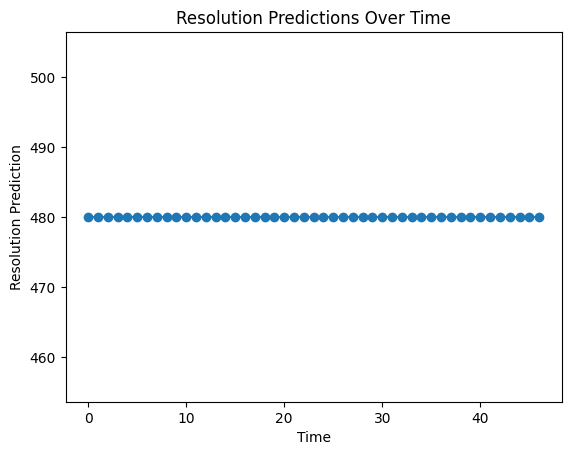

In [422]:
timestamps = nflxsession_filtered["relative_timestamp"]
numeric_timestamps = np.arange(len(timestamps))
plt.plot(numeric_timestamps, resolution_predictions, marker='o')

plt.xlabel('Time')
plt.ylabel('Resolution Prediction')
plt.title('Resolution Predictions Over Time')
plt.show()

It does not appear to be a particularly interesting graph. We have constant resolution regardless of time predicted. This only further reinforces that RandomForest is not a very good model for this type of problem.